### **This Notebook Evaluates Group KFold Cross-Validation to Better Measure how the model generalises**

Group KFold Cross-Validation prevents spectra from the same Surface appearing within both the training and test folds.

This gives a better indication of the model's ability to generalise, as it stops leakage between samples from the same fold.

Import Libraries

In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_validate
from sklearn.model_selection import LeavePGroupsOut
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

Read the spectral data

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [3]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [4]:
#df.to_csv("../../data/exosomes.raw_spectrum_400-1800.csv", index=False)

In [5]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [6]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6239205 entries, 293 to 8023281
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 333.2+ MB


#### Train an SVM Classifier on the full spectrum.

In [8]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [9]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [10]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,201210-1,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,201210-1,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,201210-1,Normal


>**The Count of Surface IDs and the number of associated samples**

In [11]:
len(wavelength_df.groupby(['SurID']))

63

In [12]:
wavelength_df.groupby(['SurID', 'Status']).size().reset_index(name='Count of Spectra per Surface')

,SurID,Status,Count of Spectra per Surface
0,201210-1,Normal,49
1,201210-2,Normal,50
2,210114-1,Normal,50
3,210114-2,Normal,50
4,210120-1,Hyperglycemia,50
...,...,...,...
58,210519-3,Hyperglycemia,50
59,210524-1,Hypoglycemia,15
60,210526-1,Hyperglycemia,50
61,210526-2,Hyperglycemia,15


It looks like each Surface is associated with 1 Status

>**The Count of Spectra with each Status**

In [13]:
df.groupby('Status')['SpecID'].nunique().reset_index(name='Spectra Count')

,Status,Spectra Count
0,Hyperglycemia,915
1,Hypoglycemia,1065
2,Normal,1065


>**The Count of Surfaces with each Status**

In [14]:
df.groupby('Status')['SurID'].nunique().reset_index(name='Surface Count')

,Status,Surface Count
0,Hyperglycemia,19
1,Hypoglycemia,22
2,Normal,22


>#### **Train a Support Vector Machine on the Raw Spectrum and evaluate it with GroupKFold cross-validation.**

Ensures that spectra from the same surface are not contained within the same CV folds out to evaluate the models ability to generalise on independent samples.

In [15]:
# def evaluate_svm(df, n_components=None):
#     # Set the Surfaces as groups
#     groups = df['SurID']
#     X = df.drop(['Status', 'SurID'], axis=1)
#     y = df['Status']

#     # Optionally adjust the number of components for PCA or keep it None for automatic selection
#     pca = PCA(n_components=n_components, svd_solver='full')

#     # Fit PCA on the data and transform the data
#     X_pca = pca.fit_transform(X)

#     # Creating the SVM classifier with a linear kernel
#     #svm = SVC(random_state=1234, kernel='linear')
#     svm = SVC(random_state=1234, kernel='linear')
    
#     # Using GroupKFold for classification tasks
#     cv = GroupKFold(n_splits=5)

#     scores = cross_validate(svm, X_pca, y, groups=groups, cv=cv, scoring=['accuracy'], n_jobs=-1)
    
#     # Displaying the results
#     print(f'{svm.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores["test_accuracy"]):.4f} +/- {np.std(scores["test_accuracy"]):.4f}')

#     # Optional: Print the amount of variance explained by each of the selected components
#     print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Should be performed within each fold to avoid leakage

In [29]:
def evaluate_svm(df, n_components=None):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Define a pipeline with PCA and the SVM classifier
    pca = PCA(n_components=n_components, svd_solver='full')
    svm = SVC(random_state=1234, kernel='linear')
    pipeline = Pipeline([('pca', pca), ('svm', svm)])

    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=5)

    scores = cross_validate(pipeline, X, y, groups=groups, cv=cv, scoring=['accuracy'], n_jobs=-1)
    
    # Displaying the results
    print(f'{pipeline.steps[-1][1].__class__.__name__} Cross-Validation Accuracy: {np.mean(scores["test_accuracy"]):.4f} +/- {np.std(scores["test_accuracy"]):.4f}')


In [16]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`~sklearn.svm.LinearSVC` or
 |  :class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer or
 |  other :ref:`kernel_approximation`.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `g

In [36]:
evaluate_svm(wavelength_df, n_components=0.95)

KeyboardInterrupt: 

>Scale the absorbances to the highest peak in each spectrum.

In [30]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalised_absorbances = absorbances / max_value
    return normalised_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [20]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755


In [31]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [33]:
scaled_raw_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.953424,0.958347,0.955242,0.948434,0.949755,0.952110,0.942389,0.957576,0.958312,0.946763,...,0.653646,0.655516,0.661592,0.653377,0.653747,0.644989,0.645355,0.642506,201210-1,Normal
201210-1-01,0.966924,0.964678,0.960813,0.960696,0.965006,0.970900,0.972982,0.965186,0.967645,0.965453,...,0.679699,0.670361,0.668847,0.665616,0.665119,0.665591,0.669153,0.673599,201210-1,Normal
201210-1-02,0.590483,0.581552,0.580569,0.584174,0.586323,0.584617,0.580471,0.577371,0.579706,0.578570,...,0.534629,0.538094,0.540060,0.535479,0.534627,0.539708,0.534086,0.533271,201210-1,Normal
201210-1-03,0.708234,0.704009,0.701777,0.705123,0.711097,0.713373,0.711019,0.714794,0.709518,0.701358,...,0.577106,0.585868,0.579843,0.582236,0.581193,0.584320,0.590369,0.579500,201210-1,Normal
201210-1-04,0.915371,0.914627,0.913193,0.912225,0.909200,0.906628,0.909496,0.906893,0.905394,0.899338,...,0.817176,0.794517,0.798681,0.799072,0.801119,0.808060,0.801357,0.816381,201210-1,Normal


In [38]:
evaluate_svm(scaled_raw_df, n_components=20)

SVC Cross-Validation Accuracy: 0.4883 +/- 0.0619


> Now see the effect of removing spikes caused by cosmic rays

Locate and correct the spikes

In [ ]:
# https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=20) # Tuned based on ml performance
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [ ]:
# # Doing this to check the combination
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [ ]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [ ]:
evaluate_svm(despiked_df)

KeyboardInterrupt: 

Despike with scaling.

In [ ]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

In [ ]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [ ]:
evaluate_svm(scaled_despiked_df)

SVC Cross-Validation Accuracy: 0.5930 +/- 0.0503


This seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [41]:
from pybaselines.whittaker import asls
from pybaselines.whittaker import airpls

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        #corrected, _ = airpls(x, lam=lam)
        return corrected

Here is an example on 1 spectrum

In [42]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
8013328,210526-3-06,293,400.22778,2367.7305,210526-3,Hyperglycemia,0.832666
8013329,210526-3-06,294,400.91116,2352.8223,210526-3,Hyperglycemia,0.827424
8013330,210526-3-06,295,401.59454,2377.9473,210526-3,Hyperglycemia,0.836259
8013331,210526-3-06,296,402.27789,2394.0313,210526-3,Hyperglycemia,0.841916
8013332,210526-3-06,297,402.96127,2376.4995,210526-3,Hyperglycemia,0.835750
...,...,...,...,...,...,...,...
8015372,210526-3-06,2337,1797.03870,1967.4805,210526-3,Hyperglycemia,0.691909
8015373,210526-3-06,2338,1797.72200,1965.0815,210526-3,Hyperglycemia,0.691066
8015374,210526-3-06,2339,1798.40550,1947.5498,210526-3,Hyperglycemia,0.684900
8015375,210526-3-06,2340,1799.08890,1951.8849,210526-3,Hyperglycemia,0.686425


/tmp/ipykernel_10254/1328060225.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

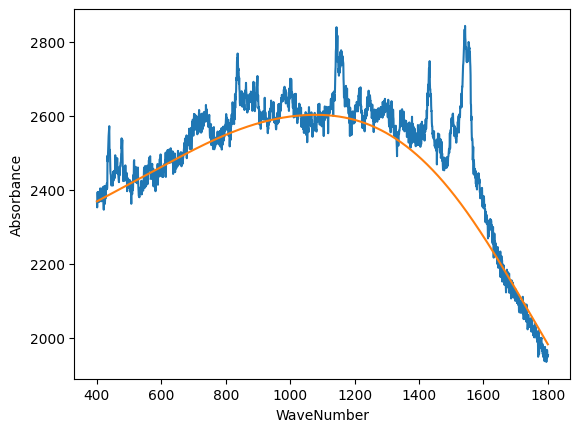

In [58]:
# lam = 10 ** 6
# p = 0.01
# window_size = 21
# poly_order = 2

# lam = 10 ** 7
# p = 0.05

lam = 10 ** 9
p = 0.1
window_size = 51
poly_order = 3
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_10254/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

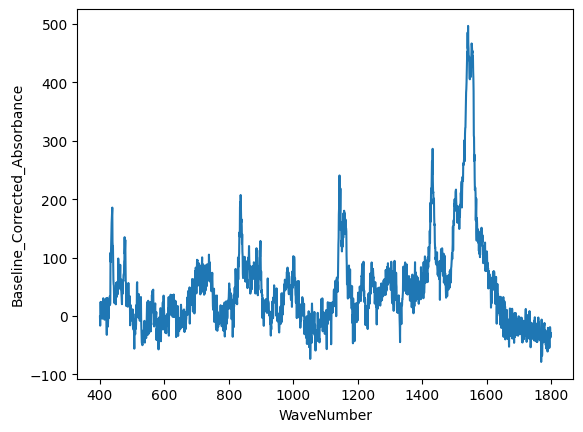

In [59]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_10254/626932300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

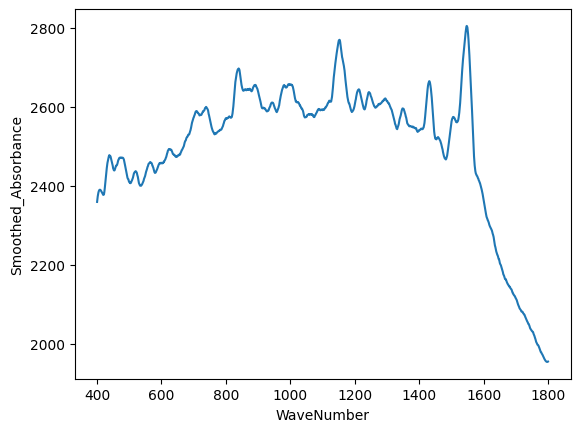

In [60]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_10254/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

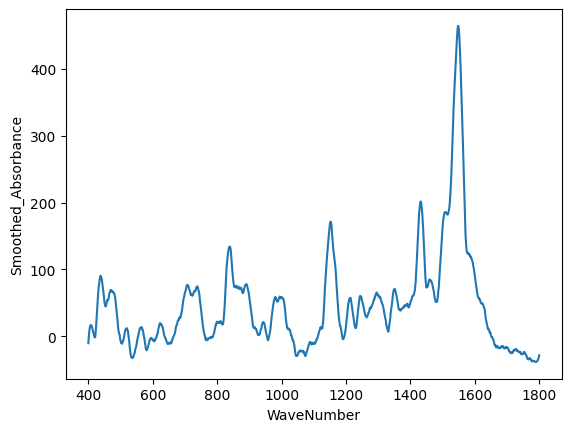

In [61]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [62]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [63]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Baseline_Corrected_Absorbance,Scaled_Baseline_Corrected
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424,28.724268,0.128976
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347,37.986485,0.178098
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242,32.379903,0.149970
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434,19.915820,0.086213
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755,22.506938,0.100676


In [64]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [65]:
baseline_corrected_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,28.724268,37.986485,32.379903,19.915820,22.506938,27.012055,9.154672,37.423690,38.931007,17.686624,...,-14.901671,-10.984931,0.722611,-14.037547,-12.898606,-28.662363,-27.531021,-32.353679,201210-1,Normal
201210-1-01,37.325252,32.947002,25.275953,25.228203,34.188153,46.368203,50.794754,35.125704,40.319354,36.051704,...,3.862698,-14.633327,-17.211851,-23.284276,-23.793000,-22.332424,-14.586748,-5.041072,201210-1,Normal
201210-1-02,129.756185,96.789727,93.202370,106.572012,114.563554,108.305096,93.022938,81.612280,90.288622,86.135663,...,-46.000031,-32.897656,-25.341080,-41.983104,-44.842528,-25.767751,-46.257574,-48.981497,201210-1,Normal
201210-1-03,172.235000,157.699680,150.046159,161.647839,182.325619,190.231199,182.158478,195.241757,177.076035,148.958413,...,-82.875963,-51.731568,-71.640571,-62.484074,-65.192376,-53.503578,-31.729780,-68.359182,201210-1,Normal
201210-1-04,98.459476,96.786008,93.417540,91.193073,83.912705,77.747537,84.955169,78.711401,75.182032,60.451463,...,-41.791709,-97.055339,-86.371268,-84.966596,-79.488524,-61.980751,-78.014378,-40.633405,201210-1,Normal


In [66]:
#evaluate_svm(baseline_corrected_df, n_components=20)

Scale the Baseline Corrected Absorbances to the highest peak.

In [67]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [68]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

In [69]:
evaluate_svm(scaled_baseline_df, n_components=200)

SVC Cross-Validation Accuracy: 0.5570 +/- 0.0711


> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

In [73]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [74]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [75]:
#evaluate_svm(smooth_df)

In [76]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [77]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [78]:
evaluate_svm(scaled_smooth_df, n_components=200)

SVC Cross-Validation Accuracy: 0.5852 +/- 0.0469


Try this on the baseline corrected spectra.

In [79]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [80]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [82]:
# evaluate_svm(smooth_baseline)

In [83]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [84]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [91]:
evaluate_svm(scaled_smooth_baseline, n_components=200)

SVC Cross-Validation Accuracy: 0.5512 +/- 0.0493


Lets try vector normalisation, where the spectra are scaled by their euclidean norm.

In [86]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalised_absorbances = absorbances / l2_norm
    return normalised_absorbances

df['Vector_Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [87]:
vector_scaled_raw = prepare_wavelength_df(df, 'Vector_Scaled_Absorbance')

In [92]:
evaluate_svm(vector_scaled_raw, 200)

SVC Cross-Validation Accuracy: 0.3871 +/- 0.0578


In [ ]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [ ]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [ ]:
evaluate_svm(scaled_smooth_baseline)

SVC Cross-Validation Accuracy: 0.5169 +/- 0.0903


----

In [ ]:
df['No_Below_Baseline'] = np.where(df['Baseline_Corrected_Absorbance'] < 0, 0, df['Baseline_Corrected_Absorbance'])

In [ ]:
no_negative = prepare_wavelength_df(df, 'No_Below_Baseline')

In [ ]:
evaluate_svm(no_negative)

SVC Cross-Validation Accuracy: 0.4988 +/- 0.0776


Then with scaling.

In [ ]:
df['Scaled_No_Below_Baseline'] = np.where(df['Scaled_Baseline_Corrected'] < 0, 0, df['Scaled_Baseline_Corrected'])

In [ ]:
scaled_no_negative = prepare_wavelength_df(df, 'Scaled_No_Below_Baseline')

In [ ]:
scaled_no_negative.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.128976,0.178098,0.149970,0.086213,0.100676,0.125083,0.033306,0.181178,0.190010,0.080635,...,0.145204,0.166450,0.228173,0.152383,0.159197,0.078193,0.084967,0.060808,201210-1,Normal
201210-1-01,0.058575,0.038068,0.001142,0.002227,0.048226,0.110281,0.133676,0.056870,0.084090,0.064134,...,0.283435,0.192222,0.180376,0.151108,0.149583,0.157876,0.197508,0.246115,201210-1,Normal
201210-1-02,0.029793,0.008733,0.006797,0.015900,0.021502,0.017828,0.008279,0.001251,0.007299,0.004995,...,0.018953,0.027788,0.033013,0.022485,0.020930,0.033653,0.020621,0.019153,201210-1,Normal
201210-1-03,0.021311,0.008559,0.002171,0.013591,0.033405,0.041407,0.034632,0.047422,0.031312,0.005999,...,0.009881,0.039055,0.021014,0.029853,0.027719,0.038901,0.059409,0.025904,201210-1,Normal
201210-1-04,0.200447,0.194779,0.182107,0.174163,0.145324,0.121094,0.152128,0.127573,0.114236,0.054608,...,0.249467,0.023993,0.071057,0.079773,0.105322,0.180585,0.117235,0.274627,201210-1,Normal


In [ ]:
evaluate_svm(scaled_no_negative)

SVC Cross-Validation Accuracy: 0.5090 +/- 0.0583


Try Min-Max Scaling Instead

In [ ]:
def min_max_scale(absorbances):
    min_value = np.min(absorbances)
    max_value = np.max(absorbances)
    return (absorbances - min_value) / (max_value - min_value)

df['MinMax_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: min_max_scale(x))

In [ ]:
min_max_raw_df = prepare_wavelength_df(df, 'MinMax_Absorbance')

In [ ]:
evaluate_svm(min_max_raw_df)

SVC Cross-Validation Accuracy: 0.5879 +/- 0.0629


In [ ]:
df['MinMax_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: min_max_scale(x))

In [ ]:
min_max_baseline_df = prepare_wavelength_df(df, 'MinMax_Baseline')

In [ ]:
min_max_baseline_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.262185,0.303795,0.279969,0.225963,0.238214,0.258888,0.181147,0.306404,0.313885,0.221238,...,0.275932,0.293929,0.346212,0.282013,0.287785,0.219169,0.224907,0.204442,201210-1,Normal
201210-1-01,0.178989,0.161104,0.128901,0.129848,0.169963,0.224081,0.244483,0.177502,0.201240,0.183836,...,0.375088,0.295541,0.285210,0.259686,0.258355,0.265588,0.300151,0.342541,201210-1,Normal
201210-1-02,0.052032,0.031454,0.029563,0.038457,0.043931,0.040341,0.031011,0.024144,0.030053,0.027802,...,0.041440,0.050073,0.055178,0.044892,0.043372,0.055803,0.043070,0.041636,201210-1,Normal
201210-1-03,0.072124,0.060034,0.053978,0.064805,0.083590,0.091177,0.084753,0.096879,0.081606,0.057606,...,0.061287,0.088947,0.071842,0.080222,0.078199,0.088800,0.108244,0.076478,201210-1,Normal
201210-1-04,0.290296,0.285265,0.274017,0.266965,0.241367,0.219860,0.247407,0.225611,0.213773,0.160845,...,0.333807,0.133671,0.175446,0.183182,0.205860,0.272666,0.216434,0.356140,201210-1,Normal


In [ ]:
evaluate_svm(min_max_baseline_df)

SVC Cross-Validation Accuracy: 0.5087 +/- 0.0694


In [ ]:
vector_scale_raw = prepare_wavelength_df(df, "Vector_Scaled_Absorbance")

In [ ]:
evaluate_svm(vector_scale_raw)

SVC Cross-Validation Accuracy: 0.3875 +/- 0.0582


Try on the baseline corrected spectra.

In [ ]:
df['Vector_Scaled_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))

In [ ]:
vector_scale_baseline = prepare_wavelength_df(df, 'Vector_Scaled_Baseline')

In [ ]:
evaluate_svm(vector_scale_baseline)

KeyboardInterrupt: 